<a href="https://colab.research.google.com/github/Balaji-2404/taxi-revenue-optimization/blob/main/Taxi_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd# Load and preprocess your data
data = pd.read_excel('/content/Data.xlsx')  # Update the path to your data

In [ ]:
# Import necessary libraries
import gym
from gym import spaces
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import random

In [ ]:
def convert_timestamps(state):
    new_state = []
    for element in state:
        if isinstance(element, pd.Timestamp):
            new_state.append(element.hour)         # Hour of the timestamp
            new_state.append(element.minute)       # Minute of the timestamp
            new_state.append(element.dayofweek)    # Day of the week of the timestamp
        else:
            new_state.append(element)
    return np.array(new_state, dtype=np.float32)

# Define your TaxiTrip environment
class TaxiTripEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, data):
        super(TaxiTripEnv, self).__init__()
        self.data = data
        self.state = 0
        self.action_space = spaces.Discrete(2)  # Assume 2 actions: accept or reject trip
        num_features = data.shape[1] * 2  # Assuming each timestamp is converted to two features
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(num_features,), dtype=np.float32)

    def step(self, action):
        self.state += 1
        done = self.state >= len(self.data)
        next_state = self.data.iloc[self.state % len(self.data)].values
        next_state = convert_timestamps(next_state)

    # Define reward logic
        if action == 1:  # If the action is to accept the trip
        # Let's say your data includes columns for trip_duration, trip_distance, and fuel_consumed
            fare_amount = next_state[12]
            extra = next_state[13]
            tip_amount = next_state[14]
            tolls_amount = next_state[15]
            dropoff_location = next_state[10]  # Hypothetical feature
            time_of_day = next_state[1]
            trip_duration = next_state[5] - next_state[2]  # Replace with the correct index or key
            trip_distance = next_state[6]  # Replace with the correct index or key
            #fuel_consumed = next_state[2]  # Replace with the correct index or key
            reward = fare_amount + tip_amount - (extra + tolls_amount)
        else:  # If the action is to reject the trip
            reward = -1

    # Optionally, if there is waiting time between trips, add a penalty
    # waiting_time = next_state[3]  # Replace with the correct index or key
    # reward -= 0.5 * waiting_time

        info = {}
        return next_state, reward, done, info

    def reset(self):
        self.state = 0
        initial_state = self.data.iloc[0].values
        initial_state = convert_timestamps(initial_state)
        return initial_state

    def render(self, mode='human', close=False):
        print(f"Current state: {self.state}")

# Define your DQN agent
class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay







In [ ]:
# Initialize the Gym environment
env = TaxiTripEnv(data)
action_size = 2  # Two possible actions: accept or reject trip

# Reset the environment to get the initial state
initial_state = env.reset()

# Process the initial state to get the actual state size
processed_state = convert_timestamps(initial_state)
actual_state_size = processed_state.shape[0]

# Print the actual state size to confirm
print(f"Actual state size: {actual_state_size}")

# Initialize DQN agent with the correct state size
dqn_agent = DQN(actual_state_size, action_size)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Actual state size: 18


In [ ]:
# Iterate over new episodes
episode_rewards = []  # Initialize the list to store rewards
for e in range(500):
    # reset state at the beginning of each game
    state = env.reset()
    state = convert_timestamps(state)
    state = np.reshape(state, [1, actual_state_size])
    total_reward = 0

    # time_t represents each frame of the game
    for time_t in range(400):
        # Decide action based on current state
        action = dqn_agent.act(state)

        # Advance the game to the next frame based on the action
        next_state, reward, done, _ = env.step(action)
        next_state = convert_timestamps(next_state)
        next_state = np.reshape(next_state, [1, actual_state_size])

        total_reward += reward  # Add reward to total_reward after it's been defined

        # Remember the previous state, action, reward, and done
        dqn_agent.remember(state, action, reward, next_state, done)

        # make next_state the new current state
        state = next_state

        # done becomes True when the game ends
        if done:
            print("episode: {}, score: {}"
                  .format(e, time_t))
            break

    episode_rewards.append(total_reward)
    print("Episode: {}, Total Reward: {}".format(e+1, total_reward))

    # train the agent with the experience of the episode
    dqn_agent.replay(2)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
Episode: 487, Total Reward: 6776.910002708435
1/1 [==============================] - 0s 30ms/step
Episode: 488, Total Reward: 6906.580005168915
1/1 [==============================] - 0s 83ms/step
Episode: 489, Total Reward: 6925.370005607605
1/1 [==============================] - 0s 26ms/step
Episode: 490, Total Reward: 6753.180003166199
1/1 [==============================] - 0s 27ms/step
Episode: 491, Total Reward: 6947.380006313324
1/1 [==============================] - 0s 35ms/step
Episode: 492, Total Reward: 6794.260001182556
1/1 [==============================] - 0s 33ms/step
Episode: 493, Total Reward: 6916.919997692108
1/1 [==============================] - 0s 28ms/step
Episode: 494, Total Reward: 6828.550000190735
1/1 [==============================] - 0s 26ms/step
Episode: 495, Total Reward: 6909.280001163483
1/1 [==============================] - 0s 50ms/step
Episode: 496, T

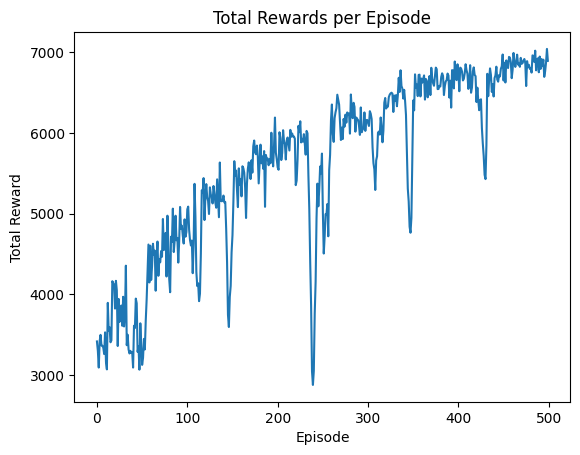

In [ ]:
import matplotlib.pyplot as plt



plt.plot(episode_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


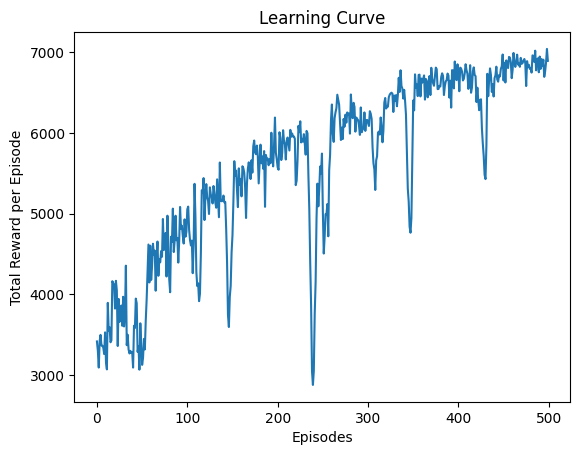

In [ ]:
plt.plot(episode_rewards)
plt.title('Learning Curve')
plt.xlabel('Episodes')
plt.ylabel('Total Reward per Episode')
plt.show()


In [ ]:
plt.bar(range(len(action_counts)), action_counts)
plt.title('Action Distribution')
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.show()


NameError: name 'action_counts' is not defined

In [ ]:
value_function = np.max(agent.Q, axis=1)  # Assuming 'agent.Q' is the Q-table
sns.heatmap(value_function.reshape((grid_size, grid_size)))
plt.title('State-Value Function')
plt.show()


NameError: name 'agent' is not defined

In [ ]:
for state in range(2):
    plt.plot(agent.Q[state, :], label=f'State {state}')
plt.legend()
plt.title('Q-Values for Actions')
plt.xlabel('Actions')
plt.ylabel('Q-Value')
plt.show()


NameError: name 'agent' is not defined

In [ ]:
plt.plot(exploration_rates)
plt.title('Exploration Rate Over Time')
plt.xlabel('Episodes')
plt.ylabel('Exploration Rate')
plt.show()


NameError: name 'exploration_rates' is not defined

In [ ]:
plt.plot(reward_variance)
plt.title('Reward Variance Over Time')
plt.xlabel('Episodes')
plt.ylabel('Variance')
plt.show()


NameError: name 'reward_variance' is not defined

In [ ]:
plt.plot(episode_lengths)
plt.title('Episode Lengths Over Time')
plt.xlabel('Episodes')
plt.ylabel('Length of Episode')
plt.show()


NameError: name 'episode_lengths' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize the Gym environment
env = TaxiTripEnv(data)
action_size = 2  # Two possible actions: accept or reject trip

# Process the initial state to get the actual state size
initial_state = env.reset()
processed_state = convert_timestamps(initial_state)
actual_state_size = processed_state.shape[0]

# Initialize DQN agent with the correct state size
dqn_agent = DQN(actual_state_size, action_size)

# Initialize lists to store metrics
episode_rewards = []  # Total rewards per episode
exploration_rates = []  # Epsilon values over episodes
episode_lengths = []  # Length of each episode
action_counts = []  # Action distribution per episode
reward_variance = []  # Variance in rewards over episodes

total_episodes = 500

# Training loop
for episode in range(total_episodes):
    state = env.reset()
    state = convert_timestamps(state)
    state = np.reshape(state, [1, actual_state_size])
    total_reward = 0
    actions_this_episode = [0] * action_size
    timestep = 0

    while True:
        action = dqn_agent.act(state)
        actions_this_episode[action] += 1

        next_state, reward, done, _ = env.step(action)
        next_state = convert_timestamps(next_state)
        next_state = np.reshape(next_state, [1, actual_state_size])

        total_reward += reward

        dqn_agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            episode_lengths.append(timestep)
            episode_rewards.append(total_reward)
            reward_variance.append(np.var(episode_rewards))
            exploration_rates.append(dqn_agent.epsilon)
            action_counts.append(actions_this_episode)
            print(f"Episode: {episode+1}, Score: {timestep}, Total Reward: {total_reward}")
            break

        timestep += 1

    dqn_agent.replay(32)  # Replay with a batch size of 32

# Plotting the results
# Total Rewards per Episode
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

# Exploration Rate Over Time
plt.figure(figsize=(12, 6))
plt.plot(exploration_rates)
plt.title('Exploration Rate Over Time')
plt.xlabel('Episode')
plt.ylabel('Exploration Rate')
plt.grid(True)
plt.show()

# Episode Lengths Over Time
plt.figure(figsize=(12, 6))
plt.plot(episode_lengths)
plt.title('Episode Lengths Over Time')
plt.xlabel('Episode')
plt.ylabel('Length of Episode')
plt.grid(True)
plt.show()

# Reward Variance Over Time
plt.figure(figsize=(12, 6))
plt.plot(reward_variance)
plt.title('Reward Variance Over Time')
plt.xlabel('Episode')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

# Action Distribution (Aggregated over all episodes)
actions_aggregated = np.sum(action_counts, axis=0)
plt.figure(figsize=(12, 6))
plt.bar(range(action_size), actions_aggregated)
plt.title('Aggregated Action Distribution')
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.xticks(range(action_size), ['Action 0', 'Action 1'])  # Replace with actual action labels if available
plt.grid(True)
plt.show()


Episode: 1, Score: 616569, Total Reward: 5980605.736161752
1/1 [==============================] - 0s 19ms/step


KeyboardInterrupt: 

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step


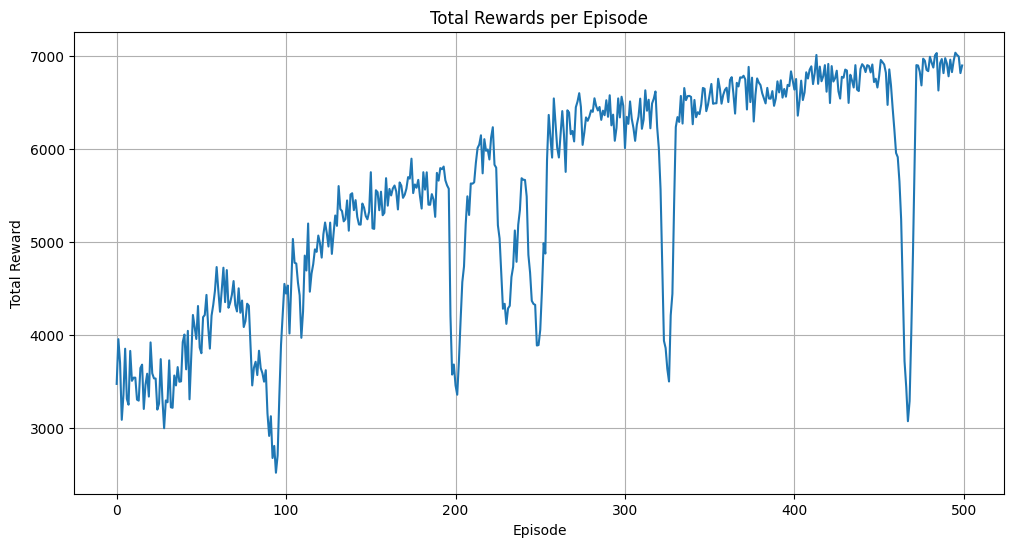

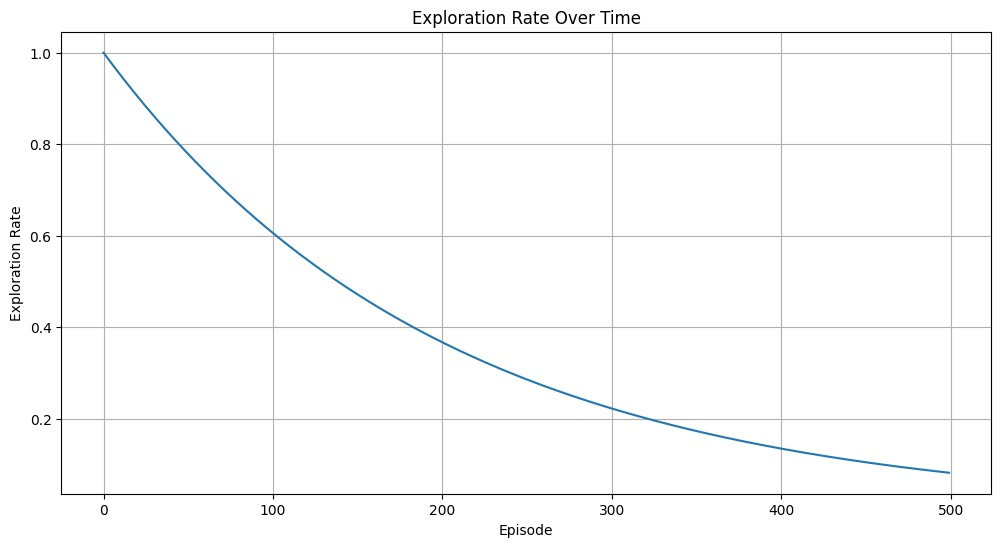

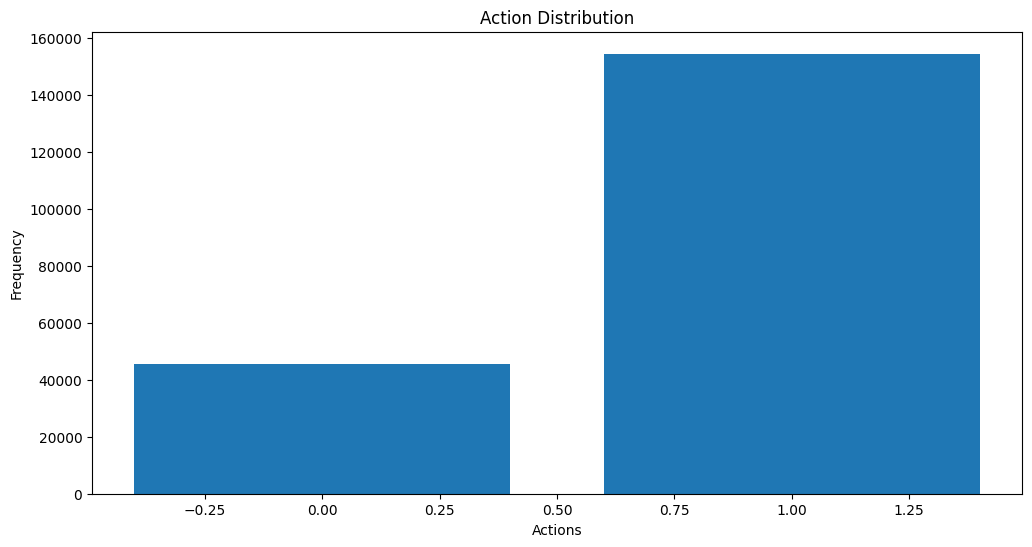

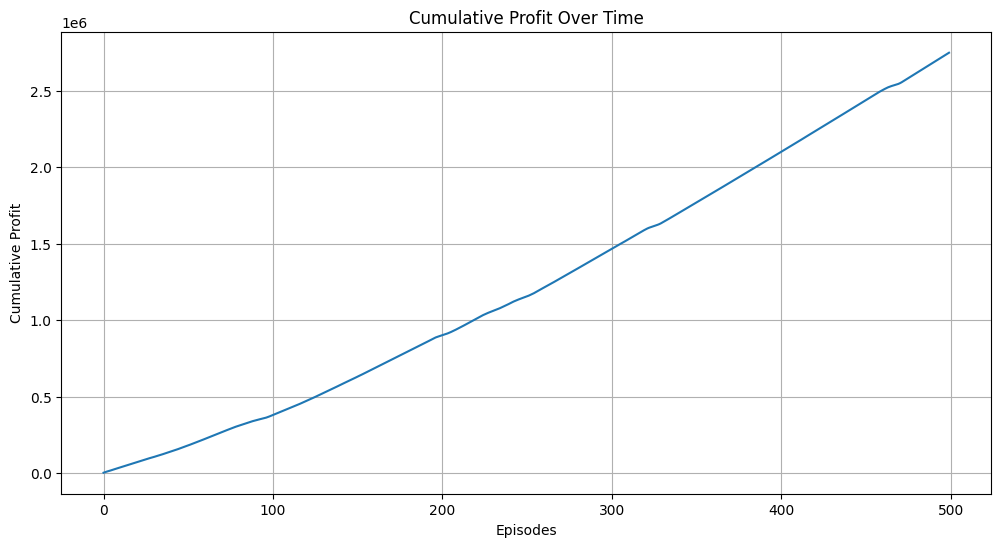

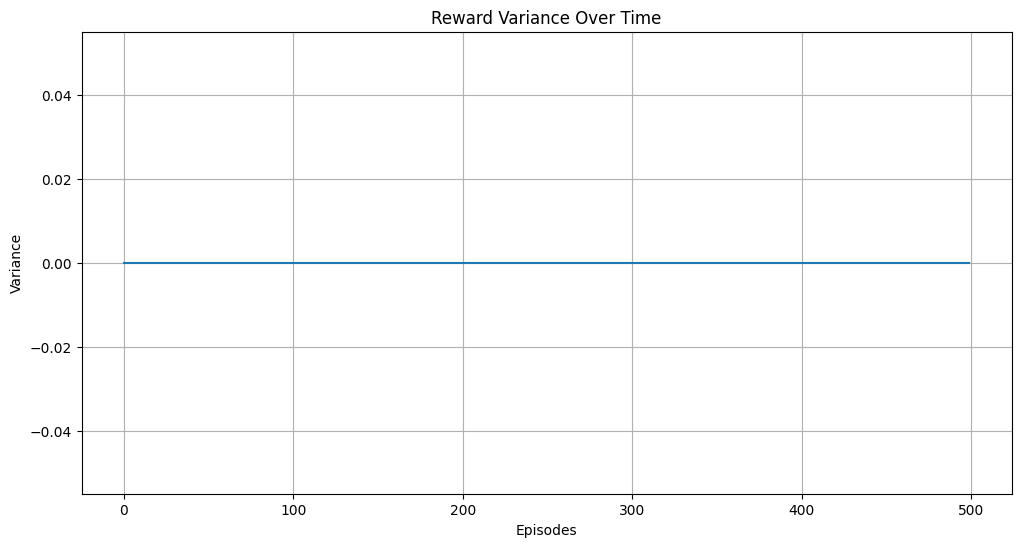

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize the Gym environment
env = TaxiTripEnv(data)
action_size = 2  # Two possible actions: accept or reject trip

# Initialize DQN agent with the actual state size
dqn_agent = DQN(actual_state_size, action_size)

# Initialize the lists to store metrics
episode_rewards = []  # Total rewards per episode
exploration_rates = []  # Epsilon values over episodes
cumulative_profit = []  # Cumulative profit over episodes
all_episode_rewards = []  # Store all episode rewards for variance calculation
action_counts = []  # Store action counts for each episode

# Specify the number of episodes for training
total_episodes = 500

# Training loop
for episode in range(total_episodes):
    state = env.reset()
    state = convert_timestamps(state)
    state = np.reshape(state, [1, actual_state_size])
    total_reward = 0
    action_count = [0] * action_size  # Track the frequency of each action

    # Iterate over each timestep within an episode
    for timestep in range(400):  # Adjust the number of timesteps as needed
        action = dqn_agent.act(state)
        action_count[action] += 1

        next_state, reward, done, _ = env.step(action)
        next_state = convert_timestamps(next_state)
        next_state = np.reshape(next_state, [1, actual_state_size])

        total_reward += reward

        dqn_agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            break

    episode_rewards.append(total_reward)
    exploration_rates.append(dqn_agent.epsilon)
    all_episode_rewards.append(total_reward)
    action_counts.append(action_count)
    cumulative_profit.append(sum(episode_rewards))  # Cumulative profit
    dqn_agent.replay(2)  # Replay with a batch size of 32

# Plotting the results
# Total Rewards per Episode
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

# Exploration Rate Over Time
plt.figure(figsize=(12, 6))
plt.plot(exploration_rates)
plt.title('Exploration Rate Over Time')
plt.xlabel('Episode')
plt.ylabel('Exploration Rate')
plt.grid(True)
plt.show()

# Action Distribution
plt.figure(figsize=(12, 6))
plt.bar(range(action_size), np.sum(action_counts, axis=0))
plt.title('Action Distribution')
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.show()

# Cumulative Profit Over Time
plt.figure(figsize=(12, 6))
plt.plot(cumulative_profit)
plt.title('Cumulative Profit Over Time')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Profit')
plt.grid(True)
plt.show()

# Reward Variance Over Time
reward_variance = [np.var(rewards) for rewards in all_episode_rewards]
plt.figure(figsize=(12, 6))
plt.plot(reward_variance)
plt.title('Reward Variance Over Time')
plt.xlabel('Episodes')
plt.ylabel('Variance')
plt.grid(True)
plt.show()


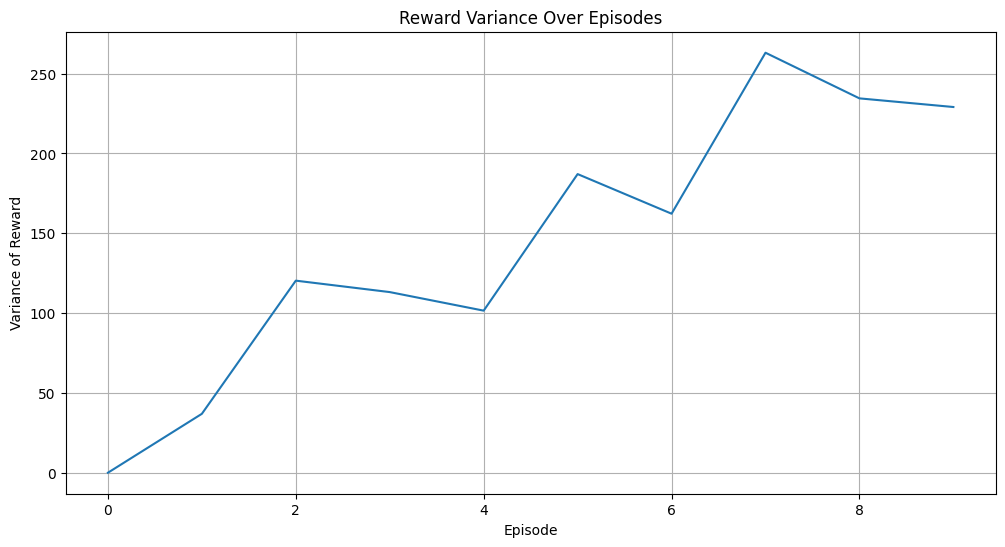

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'episode_rewards' contains the total rewards for each episode
reward_variance = [np.var(episode_rewards[:i+1]) for i in range(len(episode_rewards))]

# Plotting Reward Variance Over Time
plt.figure(figsize=(12, 6))
plt.plot(reward_variance)
plt.title('Reward Variance Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Variance of Reward')
plt.grid(True)
plt.show()


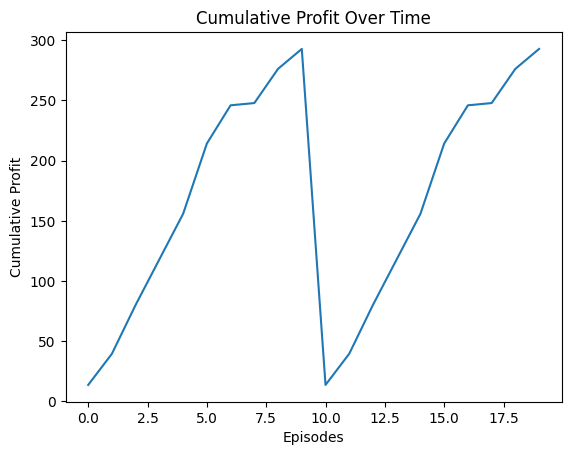

In [ ]:
for episode_reward in all_episode_rewards:
    running_total_profit += episode_reward
    cumulative_profit.append(running_total_profit)

# Plotting Cumulative Profit
plt.plot(cumulative_profit)
plt.title('Cumulative Profit Over Time')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Profit')
plt.show()